<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/pytorch_2_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/pytorch_2_intro.ipynb)

# A Quick PyTorch 2.0 Tutorial

In [1]:
import datetime
print(f"Notebook last updated: {datetime.datetime.now()}")

Notebook last updated: 2023-04-14 15:24:37.007274



## 30-second intro

PyTorch 2.0 is out!

With the main improvement being speed.

This comes via a single backwards-compatible line.

```python
torch.compile()
```

In other words, after you create your model, you can pass it to `torch.compile()` and in turn expect speedups in training and inference on newer GPUs (e.g. NVIDIA RTX 40 series, A100, H100, the newer the GPU the more noticeable the speedups).

> **Note:** There are plenty more upgrades within PyTorch 2.0 than just `torch.compile()` but since it's the main one, it's what we're going to focus on. For a full list of changes, see the [PyTorch 2.0 release notes](https://pytorch.org/blog/pytorch-2.0-release/).

### Will my old PyTorch code still work?

Yes, PyTorch 2.0 is backwards-compatible. The changes are mostly additive (new features).

That means if you already know PyTorch, such as via the [learnpytorch.io](https://learnpytorch.io) course, you can start using PyTorch 2.0 straight away. And your old PyTorch code will still work.

## Quick code examples

### Before PyTorch 2.0

In [2]:
import torch
import torchvision

model = torchvision.models.resnet50() # note: this could be any model

### Train model ###

### Test model ###

### After PyTorch 2.0

In [3]:
import torch
import torchvision

model = torchvision.models.resnet50() # note: this could be any model
compiled_model = torch.compile(model) # <- magic happens!

### Train model ### <- faster!

### Test model ### <- faster!

## Speedups

Ok so the focus of PyTorch 2.0 is speed, how much faster is it actually?

The PyTorch team ran tests across 163 open-source models from [Hugging Face Transformers](https://huggingface.co/docs/transformers/index), [timm](https://github.com/huggingface/pytorch-image-models) (PyTorch Image Models) and [TorchBench](https://github.com/pytorch/benchmark) (a curated set of popular code bases from across GitHub).

This is important because unless PyTorch 2.0 is faster on models people actually use, it’s not faster.

Using a mixture of AMP (automatic mixed precision or float16) training and float32 precision (higher precision requires more compute) the PyTorch team found that `torch.compile()` provides an average speedup of 43% in training on a NVIDIA A100 GPU.

Or 38% on timm, 76% on TorchBench and 52% on Hugging Face Transformers.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/extras-pytorch-2-speedups.png" alt="speedups for PyTorch 2.0 across various model resources" width=650/>

*PyTorch 2.0 speedups across various models from different locations. *Source:* [PyTorch 2.0 announcement post](https://pytorch.org/get-started/pytorch-2.0/).*

## 3-minute overview

> **Note:** The following is adapted from [*A Quick Introduction to PyTorch 2.0*](https://www.mrdbourke.com/pytorch-2/) on mrdbourke.com, there's also an accompanying [video explainer on YouTube](https://youtu.be/WqLKfta5Ijw).

What's happening behind the scenes of `torch.compile()`?

`torch.compile()` is designed to "just work" but there are a few technologies behind it:
* TorchDynamo
* AOTAutograd
* PrimTorch
* TorchInductor

The [PyTorch 2.0 getting started notes](https://pytorch.org/get-started/pytorch-2.0/) explain these in more detail but from a high level the two main improvements `torch.compile()` offers are:
* Fusion (or operator fusion)
* Graph capture (or graph tracing)

### Fusion

Fusion, also known as **operator fusion** is one of the best ways to make deep learning models go brrrrrr (brrrrrr is the sound your GPUs fan make when your models are training).

Operator fusion condenses (like Dragon Ball Z) many operations into one (or many to less).

Why?

Modern GPUs have so much compute power they are often not compute limited, as in, the main bottleneck to training models is how fast can you get data from your CPU to your GPU.
This is known as bandwidth or memory bandwidth.

You want to reduce your bandwidth costs as much as possible.

And feed the data hungry GPUs with as much data as possible.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/extras-memory-bandwidth-output-small.gif" alt="example of memory bandwidth costs transferring data on and off the GPU" width=950/>

So instead of performing an operation on a piece of data and then saving the result to memory (increased bandwidth costs), you chain together as many operations as possible via fusion.

A rough analogy would be using a blender to make a smoothie.

Most blenders are good at blending things (like GPUs are good at performing matrix multiplications).

Using a blender **without operator fusion** would be like adding each ingredient one by one and blending each time a new ingredient is added.
Not only is this insane, it increases your bandwidth cost.

The actual blending is fast each time (like GPU computations generally are) but you lose a bunch of time adding each ingredient one by one.

Using a blender **with operator fusion** is akin to using a blender by adding all the ingredients at the start (operator fusion) and then performing the blend once.

You lose a little time adding at the start but you gain all of the lost memory bandwidth time back.

### Graph capture

Graph capture I’m less confident explaining.

But the way I think about is that graph capture or graph tracing is:

* Going through a series of operations that need to happen, such as the operations in a neural network.
* And capturing or tracing what needs to happen ahead of time.

Computing **without graph capture** is like going to a new area and following GPS directions turn by turn.

As a good human driver, you can follow the turns quite easily but you still have to think about each turn you take.

This is the equivalent to PyTorch having to look up what each operation does as it does it.

As in, to perform an addition, it has to look up what an addition does before it can perform it.

It does this quickly but there’s still non-zero overhead.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/extras-graph-capture.gif" alt="Graph capture" width="950"/>

*Example of graph capture, mapping out the steps in a neural network and then capturing every operation that needs to happen ahead of time.*

Computing **with graph capture** is like driving through your own neighbourhood.

You barely think about what turns to make.

Sometimes you get out of the car and realise you can’t remember the last 5 minutes of the drive.

Your brain was functioning on autopilot, minimal overhead.

However, it took you some time upfront to remember how to drive to your house.

This is a caveat of graph capture, it takes a little time upfront to memorize the operations that need to happen but subsequent computations should be faster.

Of course, this is a quick high-level overview of what’s happening behind the scenes of torch.compile()but it's how I understand it.

For more on fusion and graph tracing, I’d recommend Horace He’s [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) blog post.

## Things to note

Since PyTorch 2.0 was just released, there are a few limitations with some of the features.

One of the main ones being with exporting models.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/extras-pytorch-2-limitations.png" alt="PyTorch 2 limitations" width=650/>

*There are a few caveats when using the PyTorch 2.0 features, such as not being about to export to mobile devices when using the `torch.compile()` default options. However, there are work arounds to this and improved exporting is on the PyTorch 2.x roadmap. *Source:* [PyTorch 2.0 announcement post](https://pytorch.org/get-started/pytorch-2.0/).*

However, these will likely be fixed in future releases.

Another main limitation is that because the features of PyTorch 2.0 are designed for newer hardware, old GPUs and desktop-class GPUs (e.g. NVIDIA RTX 30 series) will likely see less speedups than newer hardware.

## What we're going to cover

Since many of the upgrades in PyTorch 2.0 are speed focused and happen behind the scenes (e.g. PyTorch takes care of them for you), in this notebook we're going to run a compartive speed test.

Namely we'll make two of the same models, one using the default PyTorch setup and the other using the new `torch.compile()` setup and we'll train them on the same dataset.

1. Model 1 - no `torch.compile()`.
2. Model 2 - `torch.compile()`.

We'll then compare the training/testing times of both models for single run and multiple runs.

| **Experiment** | **Model** | **Data** | **Epochs** | **Batch size** | **Image size** | **`torch.compile()`** |  
|----- |-----| -----| -----| -----| -----| -----|
| 1 (single run) | [ResNet50](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet50.html) | [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10) | 5 | 128 | 224 | No |
| 2 (single run) | ResNet50 | CIFAR10 | 5 | 128 | 224 | Yes |
| 3 (multi-run) | ResNet50 | CIFAR10 | 3x5 | 128 | 224 | No |
| 4 (multi-run) | ResNet50 | CIFAR10 | 3x5 | 128 | 224 | Yes |

We've chosen ResNet50 and CIFAR10 here for ease of access or use, however, you could substitute any model/dataset you like.

The biggest speedups I've noticed with PyTorch 2.0 are when the GPU computes on as much data as possible (e.g. larger batch size/image size/data size/model size). 

> **Note:** Depending on the size of your GPU, you may have to lower the batch size (or image size) to fit the model on your GPU. For example, if you're using a GPU with 8GB of memory or less, you may have to lower the batch size to 64 or 32.

## 0. Getting setup

To get setup we'll first check for PyTorch 2.x+ and install it if it's not available. 

You can see how to install PyTorch 2.x on your own system in the [PyTorch documentation](https://pytorch.org/get-started/locally/).

> **Note:** If you're running on Google Colab, you'll need to setup a GPU: runtime -> change runtime type -> hardware accelerator. The best speedups are on newer NVIDIA/AMD GPUs (this is because PyTorch 2.0 leverages newer GPU hardware) such as the NVIDIA A100 and above. This tutorial focuses on NVIDIA GPUs.

In [4]:
import torch

# Check PyTorch version
pt_version = torch.__version__
print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")

# Install PyTorch 2.0 if necessary
if pt_version.split(".")[0] == "1": # Check if PyTorch version begins with 1 
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    print("[INFO] PyTorch 2.x installed, if you're on Google Colab, you may need to restart your runtime.\
          Though as of April 2023, Google Colab comes with PyTorch 2.0 pre-installed.")
    import torch
    pt_version = torch.__version__
    print(f"[INFO] Current PyTorch version: {pt_version} (should be 2.x+)")
else:
    print("[INFO] PyTorch 2.x installed, you'll be able to use the new features.")

[INFO] Current PyTorch version: 2.0.0+cu118 (should be 2.x+)
[INFO] PyTorch 2.x installed, you'll be able to use the new features.


Wonderful!

Now PyTorch 2.x is installed, let's try out the new features!

## 1. Get GPU info

Time to get GPU info.

Why?

Many of the speedups PyTorch 2.0 offers are best experienced on newer NVIDIA GPUs (we're focused on NVIDIA GPUs for now).

This is because PyTorch 2.0 takes advantage of the new hardware on newer GPUs.

How do you tell what's a newer GPU?

Generally, a *newer* GPU will have a compute capability score of 8.0 or higher.

You can see a list of [NVIDIA GPU compute capability scores](https://developer.nvidia.com/cuda-gpus) on NVIDIA's developer page.

Here are some scores of NVIDIA GPUs released in 2020 or later:

| **NVIDIA GPU** | **Compute capability score** | **GPU Type** | **Release year** | **Architecture** |
|----- |-----| -----| -----| -----| 
| RTX 4090 | 8.9 | Desktop-class | 2022 | [Ada Lovelace](https://www.nvidia.com/en-au/geforce/ada-lovelace-architecture/) |
| RTX 4080 | 8.9 | Desktop-class | 2022 | Ada Lovelace |
| RTX 4070 Ti | 8.9 | Desktop-class | 2022 | Ada Lovelace |
| RTX 3090 | 8.6 | Desktop-class | 2020 | [Ampere](https://en.wikipedia.org/wiki/Ampere_(microarchitecture)) |
| RTX 3080 | 8.6 | Desktop-class | 2020 | Ampere| 
| RTX 3070 | 8.6 | Desktop-class | 2020 | Ampere |  
| RTX 3060 Ti | 8.6 | Desktop-class | 2020 | Ampere | 
| H100 | 9.0 | Datacenter-class | 2022 | [Hopper](https://developer.nvidia.com/blog/nvidia-hopper-architecture-in-depth/) | 
| A100 | 8.0 | Datacenter-class | 2020 | Ampere |
| A10 | 8.6 | Datacenter-class | 2021 | Ampere |

GPUs with a compute capability score of 8.0 or above are likely to see the biggest speedups.

And GPUs which are datacenter-class (e.g. A100, A10, H100) are likely to see more significant speedups than desktop-class GPUs (e.g. RTX 3090, RTX 3080, RTX 3070, RTX 3060 Ti).

We can check the compute capbility score of our GPU using [`torch.cuda.get_device_capability()`](https://pytorch.org/docs/stable/generated/torch.cuda.get_device_capability.html).

This will output a tuple of `(major, minor)` compute capability scores, for example, `(8, 0)` for the A100.

We'll also get some other details about our GPU such as the name and other info using [`nvidia-smi`](https://developer.nvidia.com/nvidia-system-management-interface).  

> **Resource:** For an in-depth comparison of many different NVIDIA GPUs and their speeds, costs and tradeoffs, I'd recommend reading Tim Dettmers' [*Which GPU for deep learning?*](https://timdettmers.com/2023/01/30/which-gpu-for-deep-learning/) blog post.

In [5]:
# Make sure we're using a NVIDIA GPU
if torch.cuda.is_available():
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

  # Get GPU name
  gpu_name = !nvidia-smi --query-gpu=gpu_name --format=csv
  gpu_name = gpu_name[1]
  GPU_NAME = gpu_name.replace(" ", "_") # remove underscores for easier saving
  print(f'GPU name: {GPU_NAME}')

  # Get GPU capability score
  GPU_SCORE = torch.cuda.get_device_capability()
  print(f"GPU capability score: {GPU_SCORE}")
  if GPU_SCORE >= (8, 0):
    print(f"GPU score higher than or equal to (8, 0), PyTorch 2.x speedup features available.")
  else:
    print(f"GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).")
  
  # Print GPU info
  print(f"GPU information:\n{gpu_info}")

else:
  print("PyTorch couldn't find a GPU, to leverage the best of PyTorch 2.0, you should connect to a GPU.")

GPU name: NVIDIA_TITAN_RTX
GPU capability score: (7, 5)
GPU score lower than (8, 0), PyTorch 2.x speedup features will be limited (PyTorch 2.x speedups happen most on newer GPUs).
GPU information:
Fri Apr 14 15:24:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:01:00.0 Off |                  N/A |
| 40%   50C    P8     9W / 280W |    260MiB / 24576MiB |      0%      Default |
|                               |                  

### 1.1 Globally set devices

One of my favourite new features in PyTorch 2.x is being able to set the [default device type](https://pytorch.org/tutorials/recipes/recipes/changing_default_device.html ) via:
* Context manager
* Globally

Previously, you could only set the default device type via:
* `tensor.to(device)`

Let's see these two new device settings in action.

In [6]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device with context manager (requires PyTorch 2.x+)
with torch.device(device):
    # All tensors created in this block will be on device
    layer = torch.nn.Linear(20, 30)
    print(f"Layer weights are on device: {layer.weight.device}")
    print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


Now how about setting the global device?

This will mean that any tensors created without an explicit device will be created on the device you set by default.

In [7]:
import torch

# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set the device globally
torch.set_default_device(device)

# All tensors created will be on the global device by default
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cuda:0
Layer creating data on device: cuda:0


And now back to CPU.

In [8]:
import torch 

# Set the device globally
torch.set_default_device("cpu")

# All tensors created will be on "cpu"
layer = torch.nn.Linear(20, 30)
print(f"Layer weights are on device: {layer.weight.device}")
print(f"Layer creating data on device: {layer(torch.randn(128, 20)).device}")

Layer weights are on device: cpu
Layer creating data on device: cpu


## 2. Setting up the experiments 

Okay, time to measure speed!

To keep things simple, as we discussed we're going to run a series of four experiments, all with:

* **Model:** ResNet50 (from [TorchVision](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html))
* **Data:** CIFAR10 (from [TorchVision](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html))
* **Epochs:** 5 (single run) and 3x5 (multiple runs)
* **Batch size:** 128
* **Image size:** 224

Each experiment will be run with and without `torch.compile()`.

Why the single and multiple runs?

Because we can measure speedups via a single run, however, we'll also want to run the tests multiple times to get an average (just to make sure the results from a single run weren't a fluke or something went wrong). 

> **Note:** Depending on the amount of memory your GPU has, you may have to lower the batch size or the image size. This tutorial is focused on using an NVIDIA A100 GPU with 40GB of memory, the amount of memory on this GPU means it can handle a larger batch size. As of April 2023, NVIDIA A100 GPUs are available via Google Colab Pro. 

Let's start by importing `torch` and `torchvision` and setting the target device.

In [9]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")

# Set the target device
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

PyTorch version: 2.0.0+cu118
TorchVision version: 0.15.1+cu118
Using device: cuda


### 2.1 Create model and transforms

Let's now create our model and transforms.

We'll use the same setup to create the model and transforms we covered in [06. PyTorch Transfer Learning section 2.2](https://www.learnpytorch.io/06_pytorch_transfer_learning/).

In essence, we'll create the model and transforms for the model using the [`torchvision.models`](https://pytorch.org/vision/stable/models.html) API.

We can get the weights and transforms for ResNet50 using the following:
* `model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2` (this requires `torchvision` 0.14 or later).
* `transforms = model_weights.transforms()` (once we have the weights, we can get the appropriate transforms for the model).

> **Note:** We'll count the model's parameters to see how big of a model we're working with. The more parameters in a model, the larger GPU memory you'll need to train it. However, the more parameters your model has, the more GPU memory it uses, the larger *relative* speedup you'll often see. Meaning, a larger model may take longer to train in total, however, on a relative basis because it's using more GPU power, it could be faster than a smaller model. As in, a model with 10M parameters may take only 5x longer to train than a model with 1M parameters (10x the size but only 5x the training time). 

In [10]:
# Create model weights and transforms
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # <- use the latest weights (could also use .DEFAULT)
transforms = model_weights.transforms()

# Setup model
model = torchvision.models.resnet50(weights=model_weights)

# Count the number of parameters in the model 
total_params = sum(
    param.numel() for param in model.parameters() # <- all params
	# param.numel() for param in model.parameters() if param.requires_grad # <- only trainable params
)

print(f"Total parameters of model: {total_params} (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)")
print(f"Model transforms:\n{transforms}")

Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Now let's turn the above code into a function so we can replicate it later, we'll also adjust the last layer's (`model.fc`) output features to match the number of classes in CIFAR10 (10).

In [11]:
def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)
  
  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048, 
                             out_features=num_classes)
  return model, transforms

model, transforms = create_model()

### 2.2 Speedups are most noticeable when a large portion of the GPU is being used

Since modern GPUs are so fast at performing operations, you will often notice the majority of *relative* speedups when as much data as possible is on the GPU.

This can be achieved by:
* **Increasing the batch size** - More samples per batch means more samples on the GPU, for example, using a batch size of 256 instead of 32.
* **Increasing data size** - For example, using larger image size, 224x224 instead of 32x32. A larger data size means that more tensor operations will be happening on the GPU.
* **Increasing model size** - For example, using a larger model such as ResNet101 instead of ResNet50. A larger model means that more tensor operations will be happening on the GPU.
* **Decreasing data transfer** - For example, setting up all your tensors to be on GPU memory, this minizes the amount of data transfer between the CPU and GPU.

All of these result in *more* data being on the GPU.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/extras-speedups-are-biggest-when-more-gpu-is-used.png" width=950 alt="speedups are biggest when more of the GPU is used"/>

You may be thinking, "but doesn't this mean that the GPU will be slower because it has to do more work?"

This is correct, operations may take longer when using *more* data on the GPU, however, they benefit from [parallelism](https://en.wikipedia.org/wiki/Parallel_computing) (many operations happening at once).

This means that although *more* operations are happening, the GPU is performing as many of them as possible simultaneously.

So while you may see speedups with smaller datasets, models, batch sizes and data sizes, however, you will tend to see the *biggest relative* speedups with increasing scale.



### 2.3 Checking the memory limits of our GPU

To take advantage of speedups at scale, let's check how much memory our GPU has.

If your GPU has less memory, you may need to decrease the batch size or image size (less potential for speedups).

We can check the memory available on our GPU using [`torch.cuda.mem_get_info()`](https://pytorch.org/docs/stable/generated/torch.cuda.mem_get_info.html#torch.cuda.mem_get_info).

This will return a tuple of `(total_free_gpu_memory, total_gpu_memory)`.

Where:
* `total_free_gpu_memory` is the amount of memory currently *not being used* on the GPU in bytes.
* `total_gpu_memory` is the total amount of memory available on the GPU in bytes. 


In [12]:
# Check available GPU memory and total GPU memory 
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 24.187 GB
Total GPU memory: 25.386 GB


Wonderful!

The takeaways here are:
1. The higher the memory available on your GPU, **the bigger your batch size can be, the bigger your model can be, the bigger your data samples can be**. 
2. For speedups, you should always be trying to use **as much of the GPU(s) as possible**.

Let's write some code to use a larger batch size if more GPU memory is available.

> **Note:** The ideal batch size you use will depend on the specific GPU and dataset and model you're working with. The code below is specifically targeted for the A100 GPU available on Google Colab Pro. However, you may to adjust it for your own GPU. As if you set the batch size too high, you may run into CUDA out of memory errors.

If the total memory on the GPU available is **above 16GB**, let's use a batch size of 128 and an image size of 224 (both of these values can be increased on GPUs with more memory).

If the total memory on the GPU available is **below 16GB**, let's use a batch size of 32 and an image size of 64 (both of these values can be altered on GPUs with less memory).

In [13]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 24.187 GB, using batch size of 128 and image size 224


Now let's adjust the `transforms` to use the respective `IMAGE_SIZE`.

In [14]:
transforms.crop_size = IMAGE_SIZE
transforms.resize_size = IMAGE_SIZE 
print(f"Updated data transforms:\n{transforms}")

Updated data transforms:
ImageClassification(
    crop_size=224
    resize_size=224
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 2.4  More potential speedups with TF32

TF32 stands for TensorFloat-32, a data format which is a combination of 16-bit and 32-bit floating point numbers.

You can read more about how it works on [NVIDIA's blog](https://blogs.nvidia.com/blog/2020/05/14/tensorfloat-32-precision-format/).

The main thing you should know is that it allows you to **perform faster matrix multiplications** on GPUs with the Ampere architecture and above (a compute capability score of 8.0+).

Although it's not specific to PyTorch 2.0, since we're talking about newer GPUs, it's worth mentioning.

If you're using a GPU with a compute capability score of 8.0 or above, you can enable TF32 by setting [`torch.backends.cuda.matmul.allow_tf32 = True`](https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices) (this defaults to `False`).

Let's write a check that sets it automatically for us based on our GPUs compute capability score.

> **Note:** TensorFloat32 is disabled by default (set to `False`) in PyTorch versions 1.12 onwards. This is because it [may cause inconsistent results across different devices](https://dev-discuss.pytorch.org/t/pytorch-and-tensorfloat32/504). Although this issue is not noticed for all use cases, it's worth knowing. 

In [15]:
if GPU_SCORE >= (8, 0):
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, enabling TensorFloat32 (TF32) computing (faster on new GPUs)")
  torch.backends.cuda.matmul.allow_tf32 = True
else:
  print(f"[INFO] Using GPU with score: {GPU_SCORE}, TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)")
  torch.backends.cuda.matmul.allow_tf32 = False

[INFO] Using GPU with score: (7, 5), TensorFloat32 (TF32) not available, to use it you need a GPU with score >= (8, 0)


### 2.5 Preparing datasets

Computing setup done!

Let's now create our datasets.

To keep things simple, we'll use [CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html) since it's readily available in `torchvision`.

Some info about CIFAR10 the [CIFAR10 website](https://www.cs.toronto.edu/~kriz/cifar.html):

* CIFAR10 is a dataset of 60,000 32x32 color images in 10 classes, with 6,000 images per class.
* There are 50,000 training images and 10,000 test images.
* The dataset contains 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

Although the original dataset consists of 32x32 images, we'll use the `transforms` we created earlier to resize them to 224x224 (larger images provide more information and will take up more memory on the GPU).

In [16]:
# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='.', 
                                             train=True, 
                                             download=True, 
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root='.', 
                                            train=False, # want the test split
                                            download=True, 
                                            transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

Files already downloaded and verified
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


### 2.6 Create DataLoaders

Generally GPUs aren't the bottleneck of machine learning code.

Data loading is the main bottleneck.

As in, the transfer speed from CPU to GPU.

As we're discussed before you want to get your data to the GPU as fast as possible.

Let's create our `DataLoaders` using `torch.utils.data.DataLoader`.

We'll set their `batch_size` to the `BATCH_SIZE` we created earlier.

And the `num_workers` parameter to be the number of CPU cores we have available with `os.cpu_count()`.

> **Note:** You may want to experiment with different values for `num_workers` to see what works best for your specific GPU and CPU setup. In my experience, more is better but some people have found this [generally caps out](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/3) at `4 * number_of_gpus_you_have`, for example, `num_workers = 4 * 1` for 1 GPU.

In [17]:
from torch.utils.data import DataLoader

# Create DataLoaders
import os
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Train dataloader length: 391 batches of size 128
Test dataloader length: 79 batches of size 128
Using number of workers: 16 (generally more workers means faster dataloading from CPU to GPU)


### 2.7 Create training and testing loops

Dataloaders ready!

Let's now create some training and testing loops.

These will be the same training and testing loops we created in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/) with some slight modifications.

Since we're focused on measuring speed, we're going to add a timing component to each loop to measure how long each takes to complete.

We'll do this by measuring the start and end time of each training and testing epoch with Python's [`time.time()`](https://docs.python.org/3/library/time.html#time.time) and tracking it in a dictionary.

> **Note:** One thing I found when experimenting with PyTorch 2.0 is that [`torch.inference_mode()`](https://pytorch.org/docs/stable/generated/torch.inference_mode.html) produced errors in the testing loop. So I've changed it to be [`torch.no_grad()`](https://pytorch.org/docs/stable/generated/torch.no_grad.html) which offers similar functionality but is an older method than `torch.inference_mode()`. If you find that `torch.inference_mode()` works for you, please [let me know on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/discussions) and I'll update this notebook.

In [18]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader), 
        desc=f"Training Epoch {epoch}", 
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch, 
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time
      
      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

## 3. Time models across single run

Training and testing functions ready!

Time to start training/evaluating and timing our model.

We'll start with the first experiment. 

### 3.1 Experiment 1 - Single run, no compile

For experiment 1, we'll use the following parameters: 

| **Experiment** | **Model** | **Data** | **Epochs** | **Batch size** | **Image size** | **`torch.compile()`** |  
|----- |-----| -----| -----| -----| -----| -----|
| 1 (single run) | ResNet50 | CIFAR10 | 5 | 128 | 224 | No |

We'll set the number of epochs to `5` and use a learning rate of `0.003` throughout (you can experiment with different learning rates for better results but we're focused on speed).

In [19]:
# Set the number of epochs as a constant
NUM_EPOCHS = 5

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003

> **Note:** Depending on the speed of your GPU, the following code can take a little while to run. For example, it took around 16 minutes on my local NVIDIA TITAN RTX and around 7 minutes on a NVIDIA A100 GPU on Google Colab Pro.

In [20]:
# Create model
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7734 | train_acc: 0.7333 | test_loss: 0.8021 | test_acc: 0.7477 | train_epoch_time: 184.9701 | test_epoch_time: 12.9893


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.4337 | train_acc: 0.8501 | test_loss: 0.4794 | test_acc: 0.8338 | train_epoch_time: 185.3404 | test_epoch_time: 12.9515


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3055 | train_acc: 0.8944 | test_loss: 0.4282 | test_acc: 0.8533 | train_epoch_time: 185.3870 | test_epoch_time: 13.0559


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.2268 | train_acc: 0.9198 | test_loss: 0.4387 | test_acc: 0.8580 | train_epoch_time: 185.5914 | test_epoch_time: 13.0495


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1723 | train_acc: 0.9395 | test_loss: 0.3901 | test_acc: 0.8754 | train_epoch_time: 185.5304 | test_epoch_time: 13.0517


### 3.2 Experiment 2 - Single run, with compile

Now we'll do the same experiment but this time we'll use `torch.compile()`.

| **Experiment** | **Model** | **Data** | **Epochs** | **Batch size** | **Image size** | **`torch.compile()`** |  
|----- |-----| -----| -----| -----| -----| -----|
| 2 (single run) | ResNet50 | CIFAR10 | 5 | 128 | 224 | Yes |

> **Note:** Depending on the speed of your GPU, the following code can take a little while to run. For example, it took around 16 minutes on my local NVIDIA TITAN RTX and around 7 minutes on a NVIDIA A100 GPU on Google Colab Pro.

In [21]:
# Create model and transforms
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.00491642951965332 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7585 | train_acc: 0.7364 | test_loss: 0.5852 | test_acc: 0.8004 | train_epoch_time: 196.4621 | test_epoch_time: 21.0730


Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.4288 | train_acc: 0.8521 | test_loss: 0.5468 | test_acc: 0.8108 | train_epoch_time: 169.9891 | test_epoch_time: 11.0555


Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3080 | train_acc: 0.8928 | test_loss: 0.4791 | test_acc: 0.8377 | train_epoch_time: 170.4004 | test_epoch_time: 10.9841


Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.2322 | train_acc: 0.9184 | test_loss: 0.5551 | test_acc: 0.8306 | train_epoch_time: 170.1974 | test_epoch_time: 11.0482


Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1766 | train_acc: 0.9376 | test_loss: 0.3410 | test_acc: 0.8874 | train_epoch_time: 170.0547 | test_epoch_time: 10.9239


### 3.3 Compare the results of experiment 1 and 2

Nice!

We've got two trained models:

1. One without `torch.compile()`.
2. One with `torch.compile()`.

Let's compare the results of each experiment.

To do so, we'll first create dataframes of the results of each.

Then we'll plot the results of each experiment on a bar chart.

In [22]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [23]:
# Check out the head of one of the results dataframes
single_run_no_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.773435,0.733272,0.802100,0.747725,184.970135,12.989331
1,0.433699,0.850052,0.479412,0.833762,185.340373,12.951483
2,0.305494,0.894429,0.428212,0.853343,185.386973,13.055891
3,0.226751,0.919829,0.438668,0.857991,185.591368,13.049541
4,0.172269,0.939482,0.390148,0.875396,185.530370,13.051713


Got the results for experiments 1 and 2!

Now let's write a function to take in the results and compare them with a bar chart.

We'll add some metadata to the function so it can display some information about the experiments.

Namely all of the parameters in our experiment setup:
* The dataset name.
* The model name.
* The number of epochs.
* The batch size.
* The image size.

In [24]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame, 
                          compiled_results: pd.DataFrame, 
                          multi_runs: bool=False, 
                          num_runs: int=0, 
                          save: bool=False, 
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:
    
    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"GPU: {gpu_name} | Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend();

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

Plot function ready!

Let's create a directory to store our figures in and then plot the results of our first two experiments.

[INFO] Save path for single run results: pytorch_2_results/figures/single_run_NVIDIA_TITAN_RTX_ResNet50_CIFAR10_224_train_epoch_time.png
Mean train epoch time difference: -5.364% (negative means faster)
Mean test epoch time difference: -0.02% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/single_run_NVIDIA_TITAN_RTX_ResNet50_CIFAR10_224_train_epoch_time.png


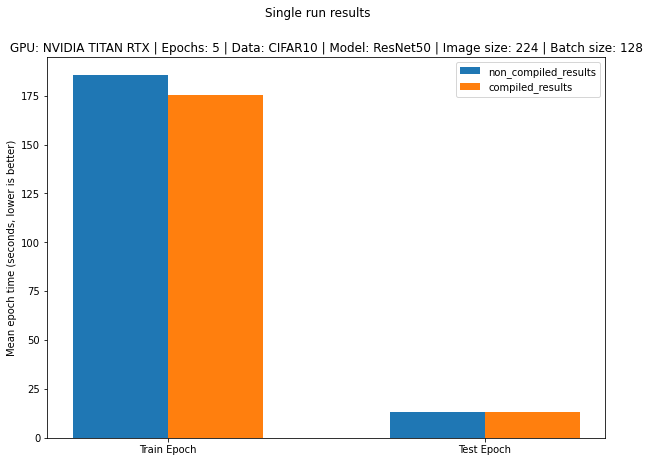

In [26]:
# Create directory for saving figures
import os
dir_to_save_figures_in = "pytorch_2_results/figures/" 
os.makedirs(dir_to_save_figures_in, exist_ok=True)

# Create a save path for the single run results
save_path_multi_run = f"{dir_to_save_figures_in}single_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"
print(f"[INFO] Save path for single run results: {save_path_multi_run}")

# Plot the results and save the figures
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df, 
                      compiled_results=single_run_compile_results_df, 
                      multi_runs=False, 
                      save_path=save_path_multi_run, 
                      save=True)

Hmm... what's happening here?

It looks like the model with `torch.compile()` took *longer* than the model without it (on an A100, this is the case, but on my local NVIDIA TITAN RTX, the compiled model is slightly faster).

Why might this be the case?

Well on a per epoch time we can see that although experiment 2 (with `torch.compile()`) was far slower for the first epoch, it started being faster than experiment 1 (without `torch.compile()`) for subsequent epochs.

This is because behind the scenes `torch.compile()` spends the first steps of a training run "warming up" the model and performing optimization steps behind the scenes.

These **optimization steps take time up front** but mean **subsequent steps should be faster**.

To test if this is true, you could try training the model above for longer (say 50 epochs rather than 5) and see what the average training times come out to be.

### 3.4 Save single run results to file with GPU details

We can save the raw data of our results to file too by exporting the dataframes as CSVs.

We'll first create a directory for storing results.

Then we'll create filepaths to save each of the target dataframes to before exporting them.

In [27]:
# Make a directory for single_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_single_run_results_dir = f"{pytorch_2_results_dir}/single_run_results"
os.makedirs(pytorch_2_single_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_non_compiled_results = f"single_run_non_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_compiled_results = f"single_run_compiled_results_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
single_run_no_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_non_compiled_results}"
single_run_compile_save_path = f"{pytorch_2_single_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving non-compiled experiment 1 results to: {single_run_no_compile_save_path}")
print(f"[INFO] Saving compiled experiment 2 results to: {single_run_compile_save_path}")

# Save the results
single_run_no_compile_results_df.to_csv(single_run_no_compile_save_path)
single_run_compile_results_df.to_csv(single_run_compile_save_path)

[INFO] Saving non-compiled experiment 1 results to: pytorch_2_results/single_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_TITAN_RTX.csv
[INFO] Saving compiled experiment 2 results to: pytorch_2_results/single_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_TITAN_RTX.csv


## 4. Time models across multiple runs

Now we've tested our model with a single run with `torch.compile()` on and off, let's do the same for multiple runs.

We're going to start by creating three functions for experiments 3 and 4.

1. **Experiment 3:** `create_and_train_non_compiled_model()` - this function will be similar to the workflow we've used for the single runs. We'll put the model creation (via `create_model()`) and training in a single function so we can call it multiple times (for multiple runs) and measure the time of each run.
2. **Experiment 4:** `create_compiled_model()` - this function will be similar to the `create_model()` function above, however, it will create a normal PyTorch model and then call `torch.compile()` on it and return it.
3. **Experiment 4:** `train_compiled_model()` - this function will take in a compiled model and train it in the same way we've been training our models for single runs.

Why separate functions 2 and 3 (`create_compiled_model()` and `train_compiled_model()`) for experiment 4?

Because calling `torch.compile()` on model means that for the first few runs, the model will be "warming up" as PyTorch calculates a bunch of optimization steps behind the scenes.

So in practice, you'll generally want to compile up front *once* and then train/perform inference with an already compiled model.

In [28]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS, 
                                        learning_rate=LEARNING_RATE, 
                                        disable_progress_bar=False):
    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)
    
    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model=compiled_model, 
                         epochs=NUM_EPOCHS, 
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
    """
    Train a compiled model and return the results.
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(compiled_model.parameters(),
                                 lr=learning_rate)
    
    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)
    
    return compile_results

### 4.1 Experiment 3 - Multiple runs, no compile

Functions ready for experiment 3 and 4! 

Let's start with experiment 3.

| **Experiment** | **Model** | **Data** | **Epochs** | **Batch size** | **Image size** | **`torch.compile()`** |  
|----- |-----| -----| -----| -----| -----| -----|
| 3 (multi-run) | ResNet50 | CIFAR10 | 3x5 | 128 | 224 | No |

We'll set the number of runs to 3 and the number of epochs to 5.

We'll create an empty list to store the results and append the results of each run to it after each run.

> **Note:** Running the following code can take quite a while depending on the speed of your GPU, for me, it took 20 minutes on a NVIDIA A100 on Google Colab Pro and around 49 minutes on a NVIDIA TITAN RTX.

In [29]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 0.8242 | train_acc: 0.7136 | test_loss: 0.5486 | test_acc: 0.8124 | train_epoch_time: 185.1112 | test_epoch_time: 12.9925
Epoch: 2 | train_loss: 0.4415 | train_acc: 0.8479 | test_loss: 0.6415 | test_acc: 0.7829 | train_epoch_time: 185.0138 | test_epoch_time: 12.9690
Epoch: 3 | train_loss: 0.3229 | train_acc: 0.8882 | test_loss: 0.4486 | test_acc: 0.8488 | train_epoch_time: 185.0366 | test_epoch_time: 12.9433
Epoch: 4 | train_loss: 0.2433 | train_acc: 0.9151 | test_loss: 0.4376 | test_acc: 0.8596 | train_epoch_time: 185.0900 | test_epoch_time: 12.9465
Epoch: 5 | train_loss: 0.1785 | train_acc: 0.9379 | test_loss: 0.4305 | test_acc: 0.8641 | train_epoch_time: 185.0405 | test_epoch_time: 13.0102
[INFO] Run 2 of 3 for non-compiled model
Epoch: 1 | train_loss: 0.8304 | train_acc: 0.7101 | test_loss: 0.6132 | test_acc: 0.7884 | train_epoch_time: 185.0911 | test_epoch_time: 13.0429
Epoch: 2 | train_loss: 0.4602 | train_acc: 0.841

Now we've got a list of results from experiment 3, let's iterate through them and create a dataframe containing all of the results.

We'll then average the results across the 3 runs by grouping by the epoch number (the index of the dataframe) and taking the mean of the results.

In [30]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.815352,0.716103,0.590690,0.796710,185.060622,13.017663
1,0.447013,0.845567,0.618526,0.790150,185.004740,12.973144
2,0.322255,0.888117,0.436471,0.852321,185.068499,12.956863
3,0.242587,0.915120,0.436207,0.858946,184.995601,12.969341
4,0.179439,0.937612,0.479547,0.854727,184.995575,12.993280


Wonderful!

We can inspect these later, let's move onto experiment 4.

### 4.2 Experiment 4 - Multiple runs, with compile

Time for experiment 4.

Running a compiled model for multiple runs.

| **Experiment** | **Model** | **Data** | **Epochs** | **Batch size** | **Image size** | **`torch.compile()`** |  
|----- |-----| -----| -----| -----| -----| -----|
| 4 (multi-run) | ResNet50 | CIFAR10 | 3x5 | 128 | 224 | Yes |

We can do this by using the `create_compiled_model()` and `train_compiled_model()` functions we created earlier.

We'll start by creating the compiled model *first* and then training it for 3 runs.

We're not worried about the results of the model (loss and accuracy) as much as how long it takes.

The reason why we compile it once at the start is that PyTorch only needs to run the optimization steps once (this can take some time) and then it can reuse them for the rest of the runs.

We'll also create an empty list just like before to store our model's results over a series of runs. 

> **Note:** Running the following code can take quite a while depending on the speed of your GPU, for me, it took 18 minutes on a NVIDIA A100 on Google Colab Pro and around 45 minutes on a NVIDIA TITAN RTX.

In [31]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

Time to compile: 0.001275777816772461 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model
Epoch: 1 | train_loss: 0.8026 | train_acc: 0.7192 | test_loss: 0.6995 | test_acc: 0.7650 | train_epoch_time: 194.3336 | test_epoch_time: 20.6106
Epoch: 2 | train_loss: 0.4440 | train_acc: 0.8483 | test_loss: 0.5565 | test_acc: 0.8089 | train_epoch_time: 169.3882 | test_epoch_time: 10.8076
Epoch: 3 | train_loss: 0.3208 | train_acc: 0.8896 | test_loss: 0.4164 | test_acc: 0.8620 | train_epoch_time: 169.9283 | test_epoch_time: 10.8361
Epoch: 4 | train_loss: 0.2329 | train_acc: 0.9197 | test_loss: 0.3635 | test_acc: 0.8792 | train_epoch_time: 169.8744 | test_epoch_time: 10.9050
Epoch: 5 | train_loss: 0.1803 | train_acc: 0.9369 | test_loss: 0.4387 | test_acc: 0.8587 | train_epoch_time: 169.6391 | test_epoch_time: 10.8240
[INFO] Run 2 of 3 for compiled model
Epoch: 1 | train_loss: 0.1875 | train_acc: 0.9347 | test_loss: 0.4187 | test_acc: 0.8714 | train_epoch_time: 169.4814 | test_epoch_time: 10.8180
Epoch: 2 | train_loss: 0.1288 | train_acc: 0.9550 | test

Experiment 4 done!

Now let's put the results together into a dataframe and take the mean across each of the runs (we'll do this by grouping by the epoch number, which is the index number of the dataframe).

In [32]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.353548,0.876332,0.517181,0.840124,177.766548,14.111428
1,0.210781,0.927845,0.474630,0.856375,169.481367,10.838063
2,0.152098,0.947577,0.450293,0.872396,169.703638,10.833619
3,0.121230,0.958177,0.424376,0.884065,169.707751,10.904810
4,0.092080,0.968116,0.481520,0.870649,169.608708,10.854486


### 4.3 Compare results of experiment 3 and 4

Multi-run experiments done!

Let's inspect the results.

We can do so with our `plot_mean_epoch_times()` function we created before.

This time we'll set the `multi_runs` parameter to `True` so that our plots reflect the fact we're plotting the results of multiple runs.

We'll make sure we've got a directory to save the figure to as well. 

Mean train epoch time difference: -7.443% (negative means faster)
Mean test epoch time difference: -11.351% (negative means faster)
[INFO] Plot saved to pytorch_2_results/figures/multi_run_NVIDIA_TITAN_RTX_ResNet50_CIFAR10_224_train_epoch_time.png


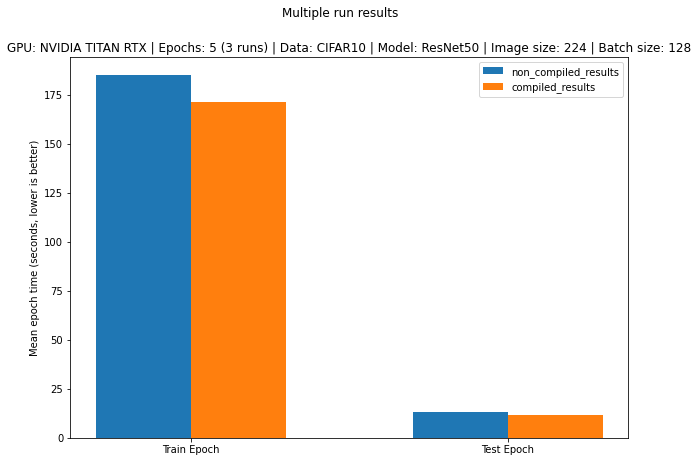

In [33]:
# Create a directory to save the multi-run figure to 
os.makedirs("pytorch_2_results/figures", exist_ok=True)

# Create a path to save the figure for multiple runs
save_path_multi_run = f"pytorch_2_results/figures/multi_run_{GPU_NAME}_{MODEL_NAME}_{DATASET_NAME}_{IMAGE_SIZE}_train_epoch_time.png"

# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df, 
                      compiled_results=compile_results_multiple_runs_df, 
                      multi_runs=True, 
                      num_runs=NUM_RUNS, 
                      save_path=save_path_multi_run, 
                      save=True)

Nice! 

Looks like the compiled model edges out the non-compiled model across multiple runs.

This is likely because on a single run (with a low amount of epochs), the compiling of the model takes quite a bit of time for the first epoch to run.

However, when the model has already been compiled and starts training for longer, the speedups from the behind the scenes optimizations start to show.

A possible extension would be to let the model train for a longer time, say 100 epochs, and see how the results compare.


### 4.4 Save multi run results to file with GPU details

Let's also save our results dataframes for experiments 3 and 4 to file to in case we'd like to inspect them later or compare them to other kinds of models.

In [34]:
# Make a directory for multi_run results
import os
pytorch_2_results_dir = "pytorch_2_results"
pytorch_2_multi_run_results_dir = f"{pytorch_2_results_dir}/multi_run_results"
os.makedirs(pytorch_2_multi_run_results_dir, exist_ok=True)

# Create filenames for each of the dataframes
save_name_for_multi_run_non_compiled_results = f"multi_run_non_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"
save_name_for_multi_run_compiled_results = f"multi_run_compiled_results_{NUM_RUNS}_runs_{DATASET_NAME}_{MODEL_NAME}_{GPU_NAME}.csv"

# Create filepaths to save the results to
multi_run_no_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_non_compiled_results}"
multi_run_compile_save_path = f"{pytorch_2_multi_run_results_dir}/{save_name_for_compiled_results}"
print(f"[INFO] Saving experiment 3 non-compiled results to: {multi_run_no_compile_save_path}")
print(f"[INFO] Saving experiment 4 compiled results to: {multi_run_compile_save_path}")

# Save the results
non_compile_results_multiple_runs_df.to_csv(multi_run_no_compile_save_path)
compile_results_multiple_runs_df.to_csv(multi_run_compile_save_path)

[INFO] Saving experiment 3 non-compiled results to: pytorch_2_results/multi_run_results/single_run_non_compiled_results_CIFAR10_ResNet50_NVIDIA_TITAN_RTX.csv
[INFO] Saving experiment 4 compiled results to: pytorch_2_results/multi_run_results/single_run_compiled_results_CIFAR10_ResNet50_NVIDIA_TITAN_RTX.csv


## 5. Possible improvements and extensions

We've explored the fundamentals of `torch.compile()` and wrote code for several experiments to test how it performs.

But there's still more we could do.

As we've discussed, many of the speedups in PyTorch 2.0 and `torch.compile()` come from using newer GPUs (e.g. A100 and above) and using as much of the GPU as possible (larger batch sizes, larger model sizes).

For even more speedups, I'd recommend researching/trying the following:

* **More powerful CPUs** - I have a sneaking suspicion that Google Colab instances are limited to 2 CPU cores, speedup numbers could be improved with more CPUs. This could be tracked via the [PyTorch Profiler](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html) (a tool to find what processes take what time).
* **Using mixed precision training** - newer GPUs have the ability to handle difference precision types (e.g. [`torch.float16`](https://pytorch.org/docs/stable/tensors.html#data-types) and [`torch.bfloat16`](https://pytorch.org/docs/stable/generated/torch.Tensor.bfloat16.html)) which enable faster training and inference. I'd suspect you'll see an even larger speedup than we've seen here by using mixed precision training. For more on this, see the [PyTorch documentation for automatic mixed precision](https://pytorch.org/docs/stable/notes/amp_examples.html#amp-examples) (also called AMP) with PyTorch. 
* **Transformer based models may see more *relative* speedups than convolutional models** - PyTorch 2.0 includes a [stable release for accelerated transformer models](https://pytorch.org/blog/pytorch-2.0-release/#stable-accelerated-pytorch-2-transformers) (models which use the attention mechanism). The main speedups come from an improved implementation of [`scaled_dot_product_attention()`](https://pytorch.org/docs/master/generated/torch.nn.functional.scaled_dot_product_attention.html?highlight=scaled_dot_product#torch.nn.functional.scaled_dot_product_attention) which automatically selects the best version of attention to use based on the hardware you're computing on. You can see more in the [dedicated PyTorch tutorial](https://pytorch.org/tutorials/intermediate/scaled_dot_product_attention_tutorial.html). 
* **Train for longer** - As previously discussed, the speedups from `torch.compile()` are likely to be more noticeable when training for longer. A great exercise would be to train over a longer number of epochs, potentially on a different dataset with a different model (e.g. a transformer) and see how the speedups compare.

## 6. Resources to learn more

I've found the following resources to be helpful learning about PyTorch 2.0 and it's upcoming features.

* [PyTorch 2.0 launch blog post](https://pytorch.org/get-started/pytorch-2.0/). 
* [PyTorch 2.0 release notes](https://pytorch.org/blog/pytorch-2.0-release/) (blog post).
    * As well as the [GitHub release notes](https://github.com/pytorch/pytorch/releases/tag/v2.0.0) (lots of info here!).
* [PyTorch default device context manager docs](https://github.com/pytorch/tutorials/pull/2220/files).
* [PyTorch 2.0 video introduction on YouTube](https://youtu.be/WqLKfta5Ijw) (created by yours truly).
* See a [tip by Sebastian Raschka](https://twitter.com/rasbt/status/1638297626385719297?s=20) to improve `torch.compile()` by performing an example batch first (warm-up the model) before continuing with further training (this explains the increased speedups with multiple runs).